# Analyze Embedding Vectors

In [1]:
import os

import pandas as pd
import numpy as np

from scipy.spatial import distance

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

import umap

/home/mhuebsch/.conda/envs/capstone/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
embed_path = "../data/embeddings"
image_dir = "../images"

## Load Dataset  
Load the BBBC021 original dataset incl. the embedding vectors created with one of the following pre-trained models  
* Inception V3 base model
* Inception V3 fine-tuned on the last 2 convolutional mixture layers
* Inception V3 last 2 layers finetuning + data augmentation (flip vertical and horizontal, random roation 90 degrees)
* DinoV2 vision transformer ViT-S/14

In [3]:
df = pd.read_csv(os.path.join(embed_path, "embeddings_l2l_MoA_only_8bit_bc.csv"))
df = df.drop(columns=["Unnamed: 0"])  # need to be removed, artifact of merging (should be fixed there)

In [4]:
df.head()

,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,...,V2038,V2039,V2040,V2041,V2042,V2043,V2044,V2045,V2046,V2047
0,2,113,Week2_180607_D10_s1_w13459A84F-B9BB-4FB2-B58E-...,Week2/Week2_24121,Week2_180607_D10_s1_w2D35FB8FC-0085-4F4D-B14A-...,Week2/Week2_24121,Week2_180607_D10_s1_w440EA0925-FF71-447F-B395-...,Week2/Week2_24121,Week2_24121,D10,...,0.598801,0.165157,0.349580,0.240558,0.232831,0.190724,0.216562,0.466217,0.217871,0.476633
1,2,114,Week2_180607_D10_s2_w111F1FA1E-8B45-451D-9C50-...,Week2/Week2_24121,Week2_180607_D10_s2_w277BE8611-E2E6-456E-838C-...,Week2/Week2_24121,Week2_180607_D10_s2_w433B4BF8D-9087-401F-89B1-...,Week2/Week2_24121,Week2_24121,D10,...,0.774047,0.220835,0.647705,0.225403,0.237141,0.195058,0.157998,0.440013,0.349144,0.429633
2,2,115,Week2_180607_D10_s3_w13C4CF98E-5824-43A6-A319-...,Week2/Week2_24121,Week2_180607_D10_s3_w2D8C8A48C-6EAF-463F-A673-...,Week2/Week2_24121,Week2_180607_D10_s3_w4E03CCDE6-86D5-4F10-9B54-...,Week2/Week2_24121,Week2_24121,D10,...,0.537046,0.446406,0.603448,0.473396,0.434939,0.248369,0.138446,0.370426,0.472364,0.404236
3,2,116,Week2_180607_D10_s4_w1E4144E18-06FF-4789-8F9F-...,Week2/Week2_24121,Week2_180607_D10_s4_w25BD84D0B-672D-4292-87B7-...,Week2/Week2_24121,Week2_180607_D10_s4_w4A0FA5EEA-D0F6-4857-9C81-...,Week2/Week2_24121,Week2_24121,D10,...,1.065903,0.259793,0.182259,0.379818,0.290877,0.238712,0.317723,0.432714,0.536339,0.550825
4,2,353,Week2_180607_D10_s1_w199106068-CEA7-4BAB-83EA-...,Week2/Week2_24141,Week2_180607_D10_s1_w20787BC73-DFAE-40D7-80BA-...,Week2/Week2_24141,Week2_180607_D10_s1_w4E09AB7C1-BAF1-4FFE-BFC7-...,Week2/Week2_24141,Week2_24141,D10,...,0.584237,0.267403,0.693121,0.609006,0.171457,0.222612,0.192032,0.727877,0.513483,0.376689


Get embedding vector columns.

In [5]:
vec_cols = [c for c in df.columns if c[0] == "V"]

---

## Embedding Vectors by Compound  
Cosine distance

In [6]:
# create new dataframe in which outliers have been removed
df_corrected = pd.DataFrame()

compound_dist_histos = dict()
compound_vec_stats = list()
compound_vec_dists = list()
for compound in df["Image_Metadata_Compound"].unique():
    df_compound = df[df["Image_Metadata_Compound"] == compound].copy()
    compound_moa = df_compound["Image_Metadata_MoA"].unique()[0]

    df_mean_vec = (
        df_compound.groupby(["Image_Metadata_Compound"])[vec_cols].mean().reset_index()
    )
    df_compound_data = df_compound[vec_cols].to_numpy()
    df_compound_mean = df_mean_vec[vec_cols].to_numpy()

    num_tot_vectors = df_compound.shape[0]

    # outlier remval using the IQR rule
    df_compound["distance_to_mean_vec"] = df_compound.apply(lambda r: distance.cosine(df_compound_mean[0], r[vec_cols]), axis=1)
    q1 = df_compound["distance_to_mean_vec"].quantile(0.25)
    q3 = df_compound["distance_to_mean_vec"].quantile(0.75)
    iqr = q3 - q1
    df_compound = df_compound[~((df_compound["distance_to_mean_vec"] < (q1 - 1.5 * iqr)) | (df_compound["distance_to_mean_vec"] > (q3 + 1.5 * iqr)))]

    df_corrected = pd.concat([df_corrected, df_compound], axis=0)
    
    num_corr_vectors = df_compound.shape[0]

    num_vectors_min_90 = np.extract(df_compound["distance_to_mean_vec"] < 0.1, df_compound["distance_to_mean_vec"]).shape[0]

    compound_vec_stats.append(
        (
            compound,
            num_tot_vectors,
            num_corr_vectors,
            num_vectors_min_90,
            (num_vectors_min_90 / num_corr_vectors) * 100,
        )
    )

    compound_histo = np.histogram(df_compound["distance_to_mean_vec"])
    compound_dist_histos[compound] = compound_histo
    compound_vec_dists.extend(list(zip([compound]*len(df_compound["distance_to_mean_vec"]), 
                                       df_compound["distance_to_mean_vec"].to_list(), 
                                       [compound_moa]*len(df_compound["distance_to_mean_vec"]))))

df_compound_vec_dists = pd.DataFrame().from_records(
    data=compound_vec_dists, 
    columns=["compound", "distance", "moa"]
)
df_compound_vec_dists = df_compound_vec_dists.sort_values(by=["moa", "compound"])

df_compound_vec_stats = pd.DataFrame.from_records(
    data=compound_vec_stats,
    columns=["compound", "total no vectors", "corrected no vectors", "corrected no vectors > 0.9", "percentage vectors > 0.9"],
)
df_compound_vec_stats.shape

(39, 5)

In [7]:
df_compound_vec_stats.head()

,compound,total no vectors,corrected no vectors,corrected no vectors > 0.9,percentage vectors > 0.9
0,ALLN,96,92,92,100.000000
1,alsterpaullone,64,62,57,91.935484
2,anisomycin,96,92,16,17.391304
3,bryostatin,64,63,47,74.603175
4,camptothecin,96,88,79,89.772727


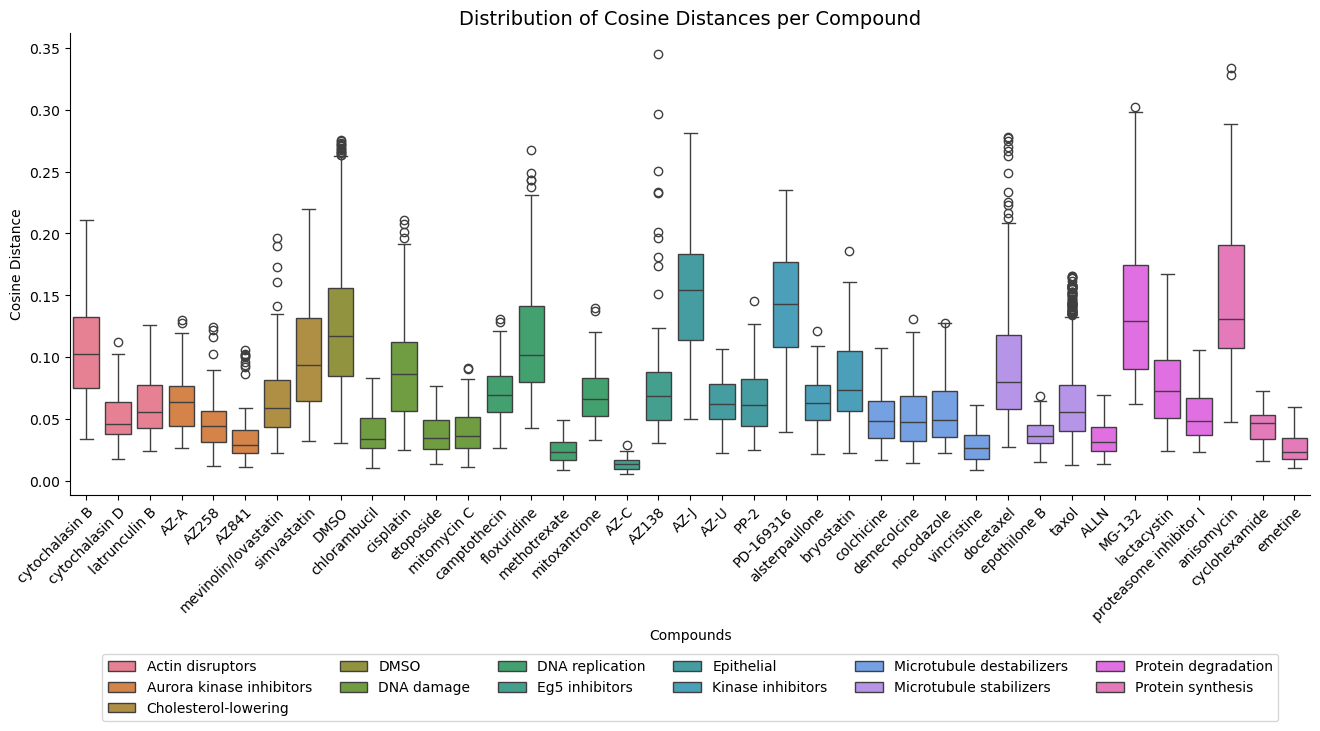

In [8]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.boxplot(data=df_compound_vec_dists, x="compound", y="distance", hue="moa", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Compounds")
ax.set_ylabel("Cosine Distance")
ax.set_title("Distribution of Cosine Distances per Compound", fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.33), fancybox=True, shadow=False, ncol=6)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [9]:
fig.savefig(os.path.join(image_dir, "Cosine_distance_embd_vecs_compound_boxplot.png"))

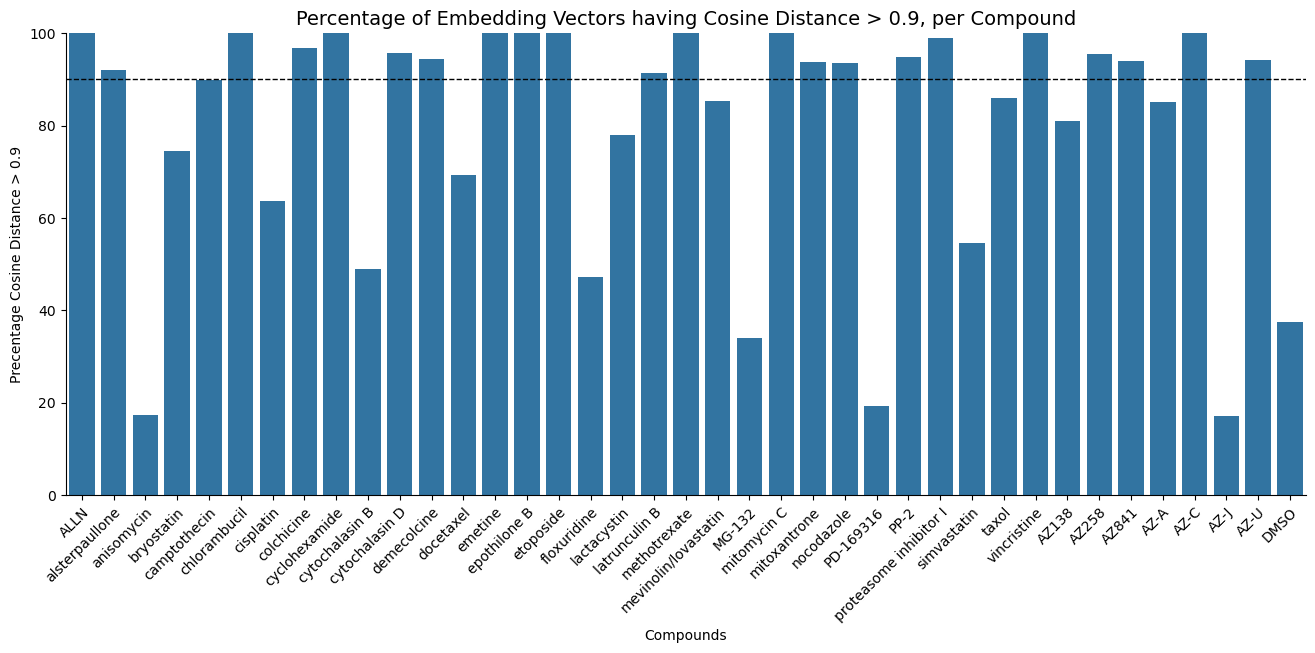

In [10]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.barplot(data=df_compound_vec_stats, x="compound", y="percentage vectors > 0.9", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Compounds")
ax.set_ylabel("Precentage Cosine Distance > 0.9")
ax.set_title("Percentage of Embedding Vectors having Cosine Distance > 0.9, per Compound", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylim(0, 100)
plt.axhline(y=90, linewidth=1, linestyle="--", color="black")

plt.show()

In [11]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_compound_gt90_barplot.png"))

## Embedding Vectors by MoA  
Cosine distance

In [12]:
df["Image_Metadata_MoA"].unique()

array(['Protein degradation', 'Kinase inhibitors', 'Protein synthesis',
       'DNA replication', 'DNA damage', 'Microtubule destabilizers',
       'Actin disruptors', 'Microtubule stabilizers',
       'Cholesterol-lowering', 'Epithelial', 'Eg5 inhibitors',
       'Aurora kinase inhibitors', 'DMSO'], dtype=object)

In [13]:
df[df["Image_Metadata_MoA"] == "Protein degradation"].shape

(384, 2062)

In [14]:
moa_dist_histos = dict()
moa_vec_stats = list()
moa_vec_dists = list()
for moa in df["Image_Metadata_MoA"].unique():
    df_moa = df[df["Image_Metadata_MoA"] == moa].copy()

    df_mean_vec = (
        df_moa.groupby(["Image_Metadata_MoA"])[vec_cols].mean().reset_index()
    )
    df_moa_data = df_moa[vec_cols].to_numpy()
    df_moa_mean = df_mean_vec[vec_cols].to_numpy()

    num_tot_vectors = df_moa.shape[0]

    # outlier remval using the IQR rule
    df_moa["distance_to_mean_vec"] = df_moa.apply(lambda r: distance.cosine(df_moa_mean[0], r[vec_cols]), axis=1)
    q1 = df_moa["distance_to_mean_vec"].quantile(0.25)
    q3 = df_moa["distance_to_mean_vec"].quantile(0.75)
    iqr = q3 - q1
    df_moa = df_moa[~((df_moa["distance_to_mean_vec"] < (q1 - 1.5 * iqr)) | (df_moa["distance_to_mean_vec"] > (q3 + 1.5 * iqr)))]

    num_corr_vectors = df_moa.shape[0]
    
    moa_dist = np.zeros((df_moa_data.shape[0]))
    for i in range(df_moa_data.shape[0]):
        moa_dist[i] = distance.cosine(df_moa_mean[0], df_moa_data[i, :])

    num_vectors_min_90 = np.extract(df_moa["distance_to_mean_vec"] < 0.1, df_moa["distance_to_mean_vec"]).shape[0]

    moa_vec_stats.append(
        (
            moa,
            num_tot_vectors,
            num_corr_vectors,
            num_vectors_min_90,
            (num_vectors_min_90 / num_corr_vectors) * 100,
        )
    )

    moa_histo = np.histogram(df_moa["distance_to_mean_vec"])
    moa_dist_histos[moa] = moa_histo
    moa_vec_dists.extend(list(zip([moa]*len(df_moa["distance_to_mean_vec"]), df_moa["distance_to_mean_vec"])))

df_moa_vec_dists = pd.DataFrame().from_records(
    data=moa_vec_dists, 
    columns=["moa", "distance"]
)
df_moa_vec_stats = pd.DataFrame.from_records(
    data=moa_vec_stats,
    columns=["moa", "total no vectors", "corrected no vectors", "corrected no vectors > 0.9", "percentage vectors > 0.9"],
)
df_moa_vec_stats.shape

(13, 5)

In [15]:
df_moa_vec_stats

,moa,total no vectors,corrected no vectors,corrected no vectors > 0.9,percentage vectors > 0.9
0,Protein degradation,384,339,284,83.775811
1,Kinase inhibitors,192,168,94,55.952381
2,Protein synthesis,288,248,213,85.887097
3,DNA replication,384,352,245,69.602273
4,DNA damage,384,339,316,93.215339
5,Microtubule destabilizers,384,362,313,86.464088
6,Actin disruptors,288,280,154,55.000000
7,Microtubule stabilizers,1608,1454,1251,86.038514
8,Cholesterol-lowering,192,173,103,59.537572
9,Epithelial,256,250,148,59.200000


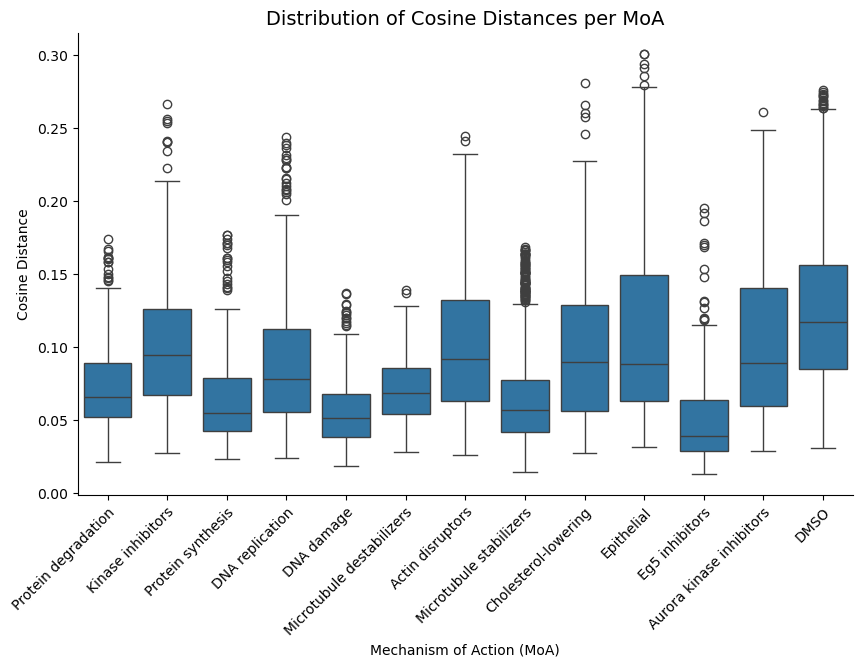

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=df_moa_vec_dists, x="moa", y="distance", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Mechanism of Action (MoA)")
ax.set_ylabel("Cosine Distance")
ax.set_title("Distribution of Cosine Distances per MoA", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [17]:
fig.savefig(os.path.join(image_dir, "Cosine_distance_embd_vecs_moa_boxplot.png"))

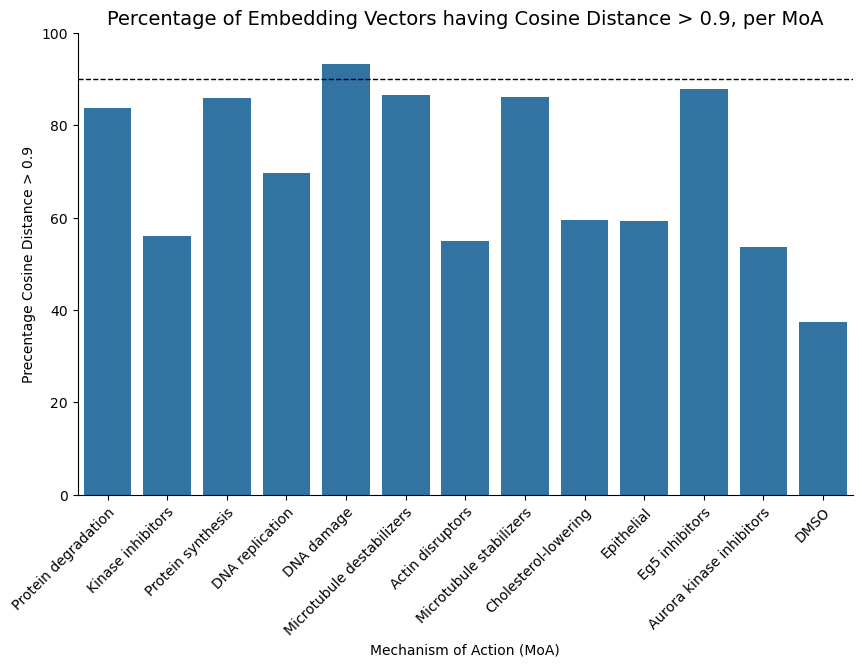

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=df_moa_vec_stats, x="moa", y="percentage vectors > 0.9", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Mechanism of Action (MoA)")
ax.set_ylabel("Precentage Cosine Distance > 0.9")
ax.set_title("Percentage of Embedding Vectors having Cosine Distance > 0.9, per MoA", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylim(0, 100)
plt.axhline(y=90, linewidth=1, linestyle="--", color="black")

plt.show()

In [19]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_moa_gt90_barplot.png"))

## Compounds Close to DMSO  
Cosine distance

In [20]:
df_dmso_mean = (
    df_corrected[df_corrected["Image_Metadata_Compound"] == "DMSO"]
    .groupby(["Image_Metadata_Compound"])[vec_cols]
    .mean()
    .reset_index()
)
dmso_mean_vec = df_dmso_mean[vec_cols].to_numpy()[0]

In [21]:
df_compounds = df[df["Image_Metadata_Compound"] != "DMSO"]
df_compounds.shape

(4840, 2062)

In [22]:
dmso_compound_dist = list()
for compound in df_compounds["Image_Metadata_Compound"].unique():
    df_compound = df_corrected[df_corrected["Image_Metadata_Compound"] == compound]
    df_mean_vec = (
        df_compound.groupby(["Image_Metadata_Compound"])[vec_cols].mean().reset_index()
    )
    mean_vec = df_compound[vec_cols].to_numpy()[0]

    dist_to_dmso = distance.cosine(dmso_mean_vec, mean_vec)
    dmso_compound_dist.append((compound, dist_to_dmso, 1 - dist_to_dmso))

df_dmso_compound_dist = pd.DataFrame().from_records(
    data=dmso_compound_dist,
    columns=["compound", "cosine distance", "cosine similarity"],
)
df_dmso_compound_dist.shape

(38, 3)

In [23]:
df_dmso_compound_dist

,compound,cosine distance,cosine similarity
0,ALLN,0.174811,0.825189
1,alsterpaullone,0.143270,0.856730
2,anisomycin,0.126878,0.873122
3,bryostatin,0.232279,0.767721
4,camptothecin,0.305984,0.694016
5,chlorambucil,0.158937,0.841063
6,cisplatin,0.169840,0.830160
7,colchicine,0.309417,0.690583
8,cyclohexamide,0.176764,0.823236
9,cytochalasin B,0.057818,0.942182


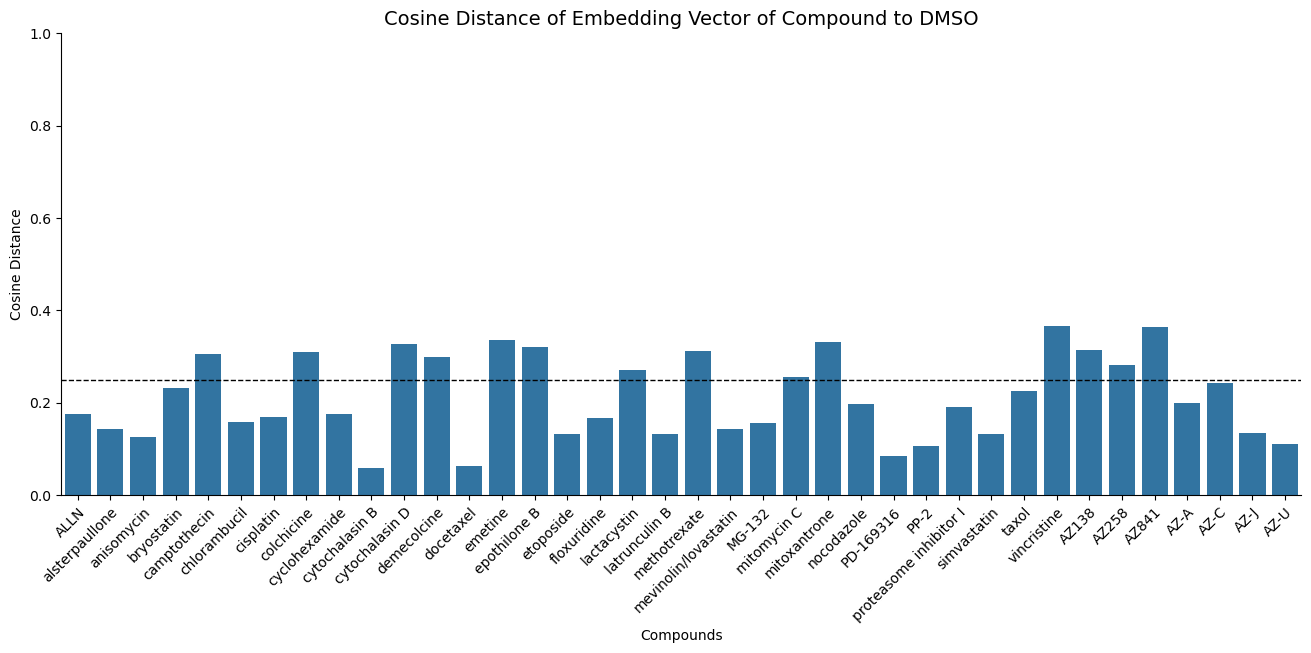

In [24]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.barplot(data=df_dmso_compound_dist, x="compound", y="cosine distance", ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Compounds")
ax.set_ylabel("Cosine Distance")
ax.set_title("Cosine Distance of Embedding Vector of Compound to DMSO", fontsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylim(0, 1)
plt.axhline(y=0.25, linewidth=1, linestyle="--", color="black")

plt.show()

In [25]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_dist_to_DMSO_barplot.png"))

## Treatment Vectors  
Per plate/well

In [26]:
df_corrected.shape

(5783, 2063)

In [27]:
metadata_cols = df_corrected.columns[:14]
metadata_cols

Index(['TableNumber', 'ImageNumber', 'Image_FileName_DAPI',
       'Image_PathName_DAPI', 'Image_FileName_Tubulin',
       'Image_PathName_Tubulin', 'Image_FileName_Actin',
       'Image_PathName_Actin', 'Image_Metadata_Plate_DAPI',
       'Image_Metadata_Well_DAPI', 'Replicate', 'Image_Metadata_Compound',
       'Image_Metadata_Concentration', 'Image_Metadata_MoA'],
      dtype='object')

In [28]:
df_treatment_vecs = (
    df_corrected.groupby(
        [
            "Image_Metadata_Plate_DAPI",
            "Image_Metadata_Well_DAPI",
            "Replicate",
            "Image_Metadata_Compound",
            "Image_Metadata_Concentration",
            "Image_Metadata_MoA",
        ]
    )[vec_cols]
    .mean()
    .reset_index()
)

In [29]:
df_treatment_vecs.shape

(1528, 2054)

In [30]:
df_treatment_vecs.head()

,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,Image_Metadata_MoA,V0,V1,V2,V3,...,V2038,V2039,V2040,V2041,V2042,V2043,V2044,V2045,V2046,V2047
0,Week10_40111,B02,1,DMSO,0.0,DMSO,0.329152,0.182670,0.653653,0.301282,...,0.493480,0.691962,0.673170,0.294648,0.758638,0.708489,0.149057,0.448668,0.244261,0.574436
1,Week10_40111,B11,1,taxol,0.3,Microtubule stabilizers,0.141502,0.795691,0.089647,0.390108,...,0.267071,0.156893,0.162518,0.906009,0.123000,0.218299,0.433497,0.831592,0.545760,0.068338
2,Week10_40111,C02,1,DMSO,0.0,DMSO,0.356045,0.227189,0.725408,0.142055,...,0.845039,0.580592,0.572725,0.262225,0.915239,0.783929,0.033380,0.609723,0.110013,0.521695
3,Week10_40111,C04,1,AZ138,10.0,Eg5 inhibitors,0.084999,0.210983,0.110711,0.213889,...,0.072046,0.338006,0.223531,-0.006275,0.146731,0.226570,0.397508,0.239948,0.202843,0.240747
4,Week10_40111,C05,1,AZ138,3.0,Eg5 inhibitors,0.148630,0.535516,0.067956,0.385845,...,0.291760,0.136017,0.152608,0.310605,0.115137,0.110368,0.360166,0.495632,0.465344,0.192329


## Dimensionality Reduction - Clustering  
Well based

In [49]:
moas = df_treatment_vecs["Image_Metadata_MoA"].unique()
treatment_vectors = df_treatment_vecs[vec_cols]
treatment_vectors.shape

(1528, 2048)

### t-SNE Clustering

In [50]:
tsne = TSNE(perplexity=42, n_components=2, metric="cosine")
tsne_treatment_vectors = tsne.fit_transform(treatment_vectors)
print(f"t-SNE embeddings shape: {tsne_treatment_vectors.shape}")

t-SNE embeddings shape: (1528, 2)


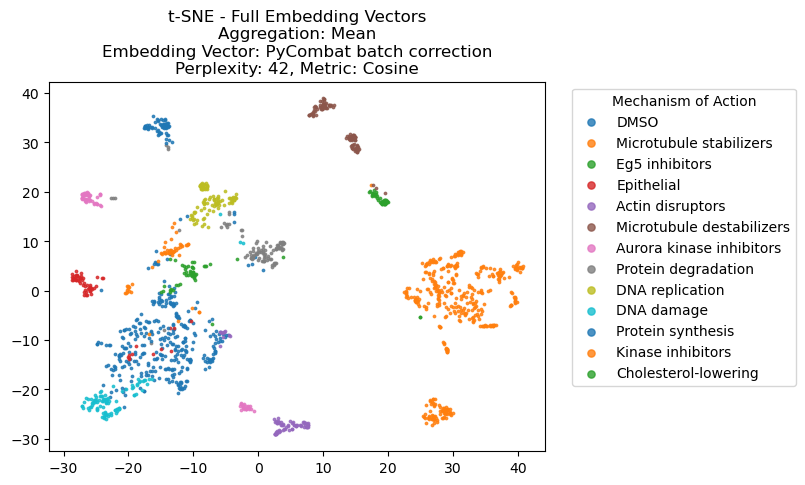

In [51]:
fig, ax = plt.subplots()

for moa in moas:
    idx = df_treatment_vecs[df_treatment_vecs["Image_Metadata_MoA"] == moa].index.values.tolist()
    ax.scatter(tsne_treatment_vectors[idx, 0], tsne_treatment_vectors[idx, 1], s=3, alpha=0.8, label=moa)
# plt.grid(True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", markerscale=3, title="Mechanism of Action")
plt.title("t-SNE - Full Embedding Vectors\nAggregation: Mean\nEmbedding Vector: PyCombat batch correction\nPerplexity: 42, Metric: Cosine")
# plt.savefig(os.path.join(image_dir, "t-sne_mean.png"), bbox_inches="tight")

plt.show()

In [52]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_compound_t-SNE.png"), bbox_inches="tight")

### UMAP Clustering

In [ ]:
umap_mean = umap.UMAP(min_dist=0.8, n_neighbors=50, metric="cosine")
umap_treatment_vectors = umap_mean.fit_transform(treatment_vectors)
print(f"UMAP embeddings shape: {umap_treatment_vectors.shape}")

In [ ]:
fig, ax = plt.subplots()

for moa in moas:
    idx = df_treatment_vecs[df_treatment_vecs["Image_Metadata_MoA"] == moa].index.values.tolist()
    ax.scatter(umap_treatment_vectors[idx, 0], umap_treatment_vectors[idx, 1], s=3, alpha=0.8, label=moa)
# plt.grid(True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", markerscale=3, title="Mechanism of Action")
plt.title("UMAP - Full Embedding Vectors\nAggregation: Mean\nEmbedding Vector: PyCombat")
# plt.savefig(os.path.join(image_dir, "umap_mean.png"), bbox_inches="tight")

plt.show()

In [ ]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_compound_UMAP.png"), bbox_inches="tight")

## Distance Matrix

In [38]:
df_compound_moa = df_treatment_vecs.groupby(["Image_Metadata_Compound", "Image_Metadata_MoA"])[vec_cols].mean().reset_index()
df_compound_moa = df_compound_moa.sort_values(["Image_Metadata_MoA", "Image_Metadata_Compound"])
df_compound_moa.shape

(39, 2050)

In [39]:
df_compound_moa.head()

,Image_Metadata_Compound,Image_Metadata_MoA,V0,V1,V2,V3,V4,V5,V6,V7,...,V2038,V2039,V2040,V2041,V2042,V2043,V2044,V2045,V2046,V2047
20,cytochalasin B,Actin disruptors,0.409627,0.407501,0.431864,0.289954,0.297678,0.371684,0.352742,0.440208,...,0.528990,0.383775,0.387407,0.348547,0.497869,0.667941,0.230737,0.354866,0.552669,0.266586
21,cytochalasin D,Actin disruptors,0.340927,0.511027,0.249576,0.432212,0.170570,0.170286,0.504425,0.267581,...,0.381562,0.508762,0.115593,0.342482,0.501421,0.880572,0.151301,0.331303,0.543962,0.150077
29,latrunculin B,Actin disruptors,0.518882,0.224677,0.429984,0.291452,0.280650,0.327055,0.389273,0.514044,...,0.661318,0.291289,0.376802,0.144440,0.456973,0.694686,0.123539,0.230027,0.552517,0.353583
1,AZ-A,Aurora kinase inhibitors,0.408155,0.105073,0.389003,0.105719,0.188379,0.261841,0.268721,0.458565,...,0.472088,0.391893,0.150473,0.053848,0.413157,0.248064,0.380544,0.294595,0.221223,0.567573
6,AZ258,Aurora kinase inhibitors,0.246073,0.182025,0.113640,0.303105,0.327593,0.099145,0.424289,0.145156,...,0.042587,0.785901,0.144270,0.109012,0.257196,0.252284,0.784735,0.192922,0.235797,0.519821


In [40]:
compounds = df_compound_moa["Image_Metadata_Compound"].to_numpy()
embed_vectors = df_compound_moa[vec_cols].to_numpy()
moas = df_compound_moa["Image_Metadata_MoA"].unique()

In [41]:
embed_vectors.shape

(39, 2048)

In [42]:
def create_embed_vec_dist_matix(embed_vectors):
    dist_matrix = np.zeros((len(embed_vectors), len(embed_vectors)))

    for i in range(len(embed_vectors)):
        for j in range(len(embed_vectors)):
            dist_matrix[i][j] = distance.cosine(embed_vectors[i], embed_vectors[j])
    return dist_matrix

In [43]:
distance_matrix = create_embed_vec_dist_matix(embed_vectors)
similarity_matrix = 1 - distance_matrix

In [44]:
def get_bounderies(df):
    moa_list = df["Image_Metadata_MoA"].to_list()
    m0 = moa_list[0]
    bounderies = list()
    for i, m in enumerate(df["Image_Metadata_MoA"].to_list()):
        if m != m0:
            bounderies.append(i)
            m0 = m
    return bounderies

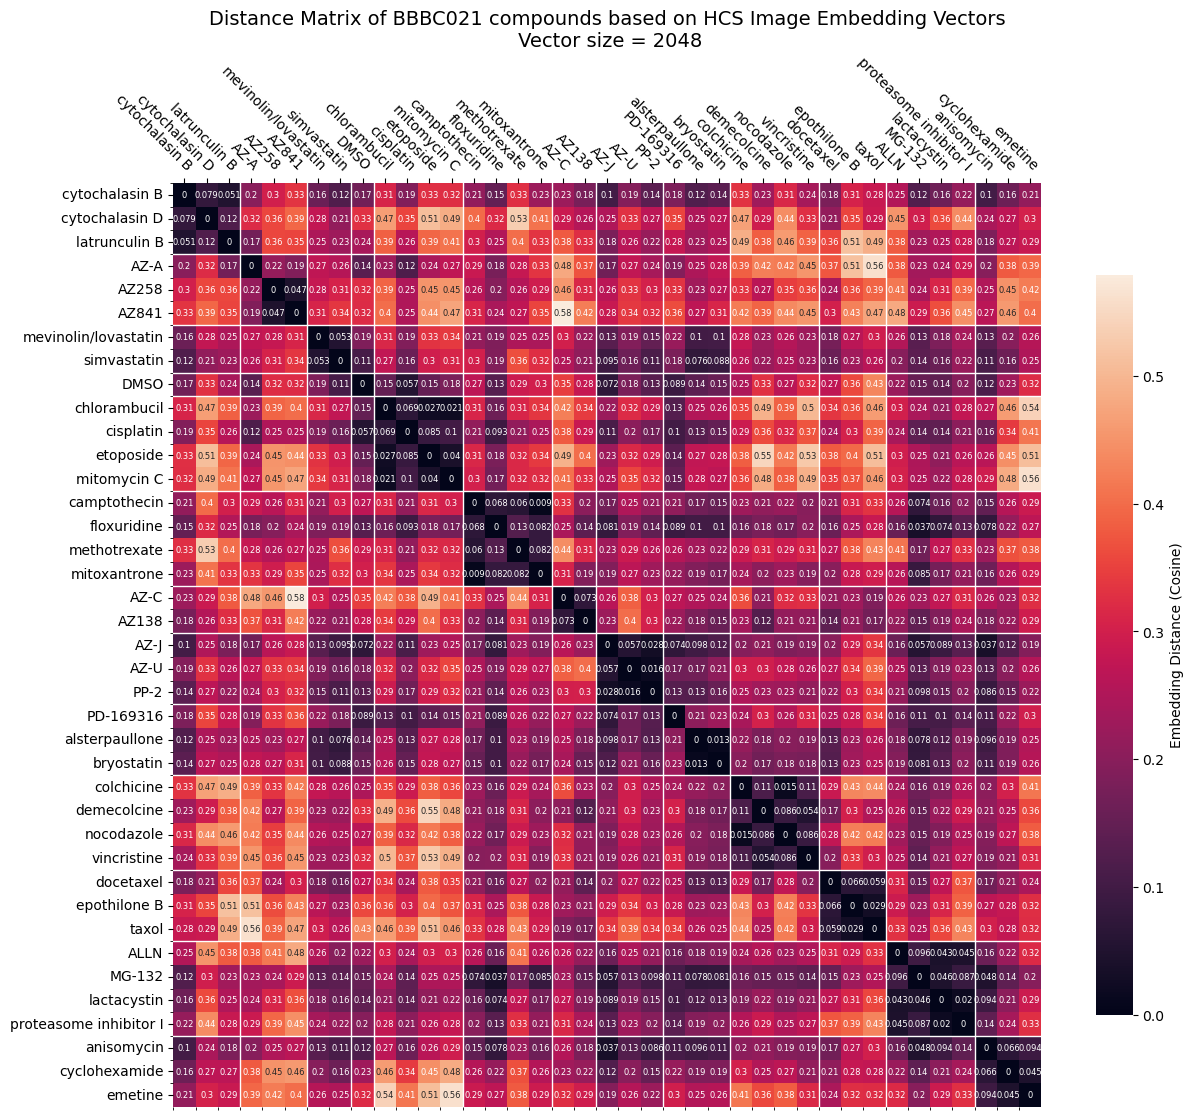

In [47]:
plot_title = "Distance Matrix of BBBC021 compounds based on HCS Image Embedding Vectors\n Vector size = 2048"

fig, ax = plt.subplots(figsize=(14,12))

sns.heatmap(distance_matrix, 
            annot=True, 
            annot_kws={"fontsize":6, "ha": "center"}, 
            fmt=".2g", 
            cbar_kws={"label": "Embedding Distance (Cosine)", "shrink": 0.8},
            ax=ax)
ax.set_yticks(range(len(compounds)), minor=True)
ax.set_yticklabels(compounds)
ax.set_xticks(range(len(compounds)), minor=True)
ax.set_xticklabels(compounds)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_title(plot_title, fontsize=14)

for i in get_bounderies(df_compound_moa):
    ax.axvline(i, color="white", linewidth=1)
    ax.axhline(i, color="white", linewidth=1)

plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")

plt.show()

In [48]:
fig.savefig(os.path.join(image_dir, "Embd_vecs_distance_matrix_compounds.png"))